# Assignment 3: Decision Tree and Random Forest

In this assignment, we are given a dataset called 'data-employee-recruitment.csv' to work on. We will use its attributes to develop an employee recruitment prediction model using Decision Tree and Random Forest.

This is the overall approach:
- Load the data
- Process the data
- Analyze the data and check if imbalanced
- Build and visualize Decision Tree model
- Build and visualize Random Forest model

##Step 1: Data loading
First and foremost, we must import necessary libraries for the training, which are Pandas, Numpy, Matplotlib, Seaborn, and Scikit-learn. There are also some useful functions from various libraries which will be loaded to help us to visualize and process data.

In [ ]:
# Load neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load Scikit-learn's functions
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# Load some useful functions
!pip install tabulate
from tabulate import tabulate
from pandas_profiling import ProfileReport
from imblearn.over_sampling import SMOTE
from IPython.display import Image
from subprocess import call

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Then, we will load the given dataset to this worksheet and read the loaded one using pandas. The dataset contains attendant background and whether he or she is looking for a job change. To confirm that the data loading is successful, we will print out the dataset as following.

In [ ]:
# Load the dataset
df = pd.read_csv("data-employee-recruitment.csv")

# Show several data samples
df.head()

enrollee_id  city_development_index  gender      relevent_experience  \
0        14569                   0.704    Male  Has relevent experience   
1        10557                   0.594  Female  Has relevent experience   
2        14095                   0.596    Male  Has relevent experience   
3        16300                   0.614    Male  Has relevent experience   
4        14550                   0.534    Male   No relevent experience   

  enrolled_university education_level major_discipline experience  \
0    Full time course        Graduate             STEM          2   
1    Full time course         Masters             STEM          9   
2    Part time course        Graduate       Humanities          2   
3    Full time course         Masters             STEM          4   
4    Full time course        Graduate             STEM         <1   

  company_size         company_type last_new_job  training_hours  target  
0        50-99              Pvt Ltd            2              71     1.0  
1        50-99  Early Stage Startup        never             217     1.0  
2      100-500              Pvt Ltd            2              12     1.0  
3        50-99              Pvt Ltd            1              20     1.0  
4        50-99  Early Stage Startup            1              52     1.0

Some useful attributes in the dataset are:

* city_development_index : developement index of the city (scaled)
* gender: gender of candidate
* relevent_experience: relevant experience of candidate
* enrolled_university: type of university course enrolled if any
* education_level: education level of candidate
* major_discipline: education major discipline of candidate
* experience: candidate's total experience in years
* company_size: number of employees in the current company of candidate
* company_type : Type of current employer
* last_new_job: difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – not looking for job change, 1 – looking for a job change

## Step 2:  Data Processing
### 2.1. Data Cleaning
Before processing the data, we will make a copy of the data to preserve the orginial one in case we did something inappropriately.

In [ ]:
# Make a data copy
data = df.copy()

Then, we will move the data label column from the dataset into a variable to make sure that the labels are not leaked into the model training process. Moreover, we will drop useless columns such as `enrollee_id`. To confirm that the removal is successful, we will print the data out.

In [ ]:
# Assign data label to variable 'labels'
labels = data["target"]

# Drop the data label and irrelavent attributes
data = data.drop(columns = ["target", "enrollee_id"], axis = 1)

### 2.2. Data Encoding

Before train a Decision Tree classifier, we must encode categorical attributes if there is any. Therefore, let's print out the list of categorical features along with their unique values.

In [ ]:
# Get the list of categorical features
cat_cols = [col for col in df.columns if df[col].dtypes=="O"]

# Visualize unique values of every categorical attributes in a table
cat_table = [['Attribute', 'Unique values']]
for col in cat_cols:
  cat_table.append([col, str(data[col].unique())])
print(tabulate(cat_table, headers = 'firstrow'))

Attribute            Unique values
-------------------  ------------------------------------------------------------------------
gender               ['Male' 'Female']
relevent_experience  ['Has relevent experience' 'No relevent experience']
enrolled_university  ['Full time course' 'Part time course']
education_level      ['Graduate' 'Masters' 'Phd']
major_discipline     ['STEM' 'Humanities' 'Other' 'No Major' 'Business Degree' 'Arts']
experience           ['2' '9' '4' '<1' '5' '3' '11' '10' '7' '12' '1' '16' '15' '8' '13' '17'
                      '>20' '6' '19' '14' '18' '20']
company_size         ['50-99' '100-500' '<10' '10000+' '1000-4999' '10/49' '500-999'
                      '5000-9999']
company_type         ['Pvt Ltd' 'Early Stage Startup' 'Funded Startup' 'NGO' 'Public Sector'
                      'Other']
last_new_job         ['2' 'never' '1' '4' '3' '>4']


It is clear that there are currently 9 categorical attributes in our dataset. However, some of them are ordinally categorical attributes, which could be turned into numerically scaled values to optimize the training time. Those attributes are: `enrolled_university`, `education_level`, `education_level`, `experience`, `company_size`, and `last_new_job`. For other attributes, one hot encoding will be applied to maintain their categorical nature.

Let's perform one hot encoding first.

In [ ]:
# Perform one hot encoding on some categorical columns
data = pd.get_dummies(data = data, columns = ["gender", "relevent_experience",
                                          "major_discipline", "company_type"])

After that, we will perform ordinal encoding. Because we cannot find any existing suitable function for this type of encoding, we decide to make our own.


In [ ]:
# Ordinal encoding function given a dictionary containing categorical-numerical pairs
def ordinal_encoding(data, col, lookup_dict):
  for i in range(len(data)):
    value = data.loc[i, col]
    if (lookup_dict.get(value) != None):
      data.loc[i, col] = lookup_dict[value]  # Assign the given numerical value
  return data.astype({col: "float64"})  # Convert datatype from object to float

Having the encoding function, we will execute it as follow:
- For `enrolled_university`, we will assign `0` to `Part time course` and `1` to `Full time course` as part time courses requires less time than full time courses do.
- For `education_level`, we will assign `0` to `Graduate`, `1` to `Master`, and `2` to `PhD` since we must go from Graduate to Master to PhD.
- For `experience`,  we will assign `0` to `<1` and `21` to `>20` since most values of this attributes are numerical except those two. Although this action will merge all >20 values into one (i.e. 21), it saves us plenty of processing time as this attribute has over 20 unique values.
- For `last_new_job`, we will assign `0` to `never` and `5` to `>4`. The intuition is the same as that of `experience`. 
- For `company_size`, we will assign `0` to `>10`, `1` to `10/49`, `2` to `50-99`, and so on because the ranges, although they. can have different sizes, can be expressed as small, medium, large, etc.


In [ ]:
# Perform ordinal encoding on some ordinally categorical columns

data = ordinal_encoding(data, "enrolled_university", {"Part time course": 0,
                                                    "Full time course": 1})

data = ordinal_encoding(data, "education_level", {"Graduate": 0,
                                                "Masters": 1, "Phd": 2})

data = ordinal_encoding(data, "experience", {"<1": 0, ">20": 21})

data = ordinal_encoding(data, "last_new_job", {"never": 0, ">4": 5})

data = ordinal_encoding(data, "company_size", {"<10": 0, "10/49": 1, "50-99": 2,
                                             '100-500': 3, '500-999': 4,
                                             '1000-4999': 5, '5000-9999': 6,
                                             '10000+': 7})

We then print out the list of categorical attributes and the dataset's first 5 entries to make sure that the encoding is successful.

In [ ]:
# Get the list of categorical features
cat_cols = [col for col in data.columns if data[col].dtypes=="O"]
cat_cols

[]

In [ ]:
# Show several data samples
data.head()

city_development_index  enrolled_university  education_level  experience  \
0                   0.704                  1.0              0.0         2.0   
1                   0.594                  1.0              1.0         9.0   
2                   0.596                  0.0              0.0         2.0   
3                   0.614                  1.0              1.0         4.0   
4                   0.534                  1.0              0.0         0.0   

   company_size  last_new_job  training_hours  gender_Female  gender_Male  \
0           2.0           2.0              71              0            1   
1           2.0           0.0             217              1            0   
2           3.0           2.0              12              0            1   
3           2.0           1.0              20              0            1   
4           2.0           1.0              52              0            1   

   relevent_experience_Has relevent experience  ...  \
0                                            1  ...   
1                                            1  ...   
2                                            1  ...   
3                                            1  ...   
4                                            0  ...   

   major_discipline_Humanities  major_discipline_No Major  \
0                            0                          0   
1                            0                          0   
2                            1                          0   
3                            0                          0   
4                            0                          0   

   major_discipline_Other  major_discipline_STEM  \
0                       0                      1   
1                       0                      1   
2                       0                      0   
3                       0                      1   
4                       0                      1   

   company_type_Early Stage Startup  company_type_Funded Startup  \
0                                 0                            0   
1                                 1                            0   
2                                 0                            0   
3                                 0                            0   
4                                 1                            0   

   company_type_NGO  company_type_Other  company_type_Public Sector  \
0                 0                   0                           0   
1                 0                   0                           0   
2                 0                   0                           0   
3                 0                   0                           0   
4                 0                   0                           0   

   company_type_Pvt Ltd  
0                     1  
1                     0  
2                     1  
3                     1  
4                     0  

[5 rows x 23 columns]

### 2.3. Attribute Reduction

The next step is to remove any highly correlated attributes (covariance > `0.65` or < `-0.65`). Since there are 23 attributes in our dataset, visualizing each pair's correlation using the traditional `corr()` function is time-consuming. Instead, we will use the correlation heatmap as below.

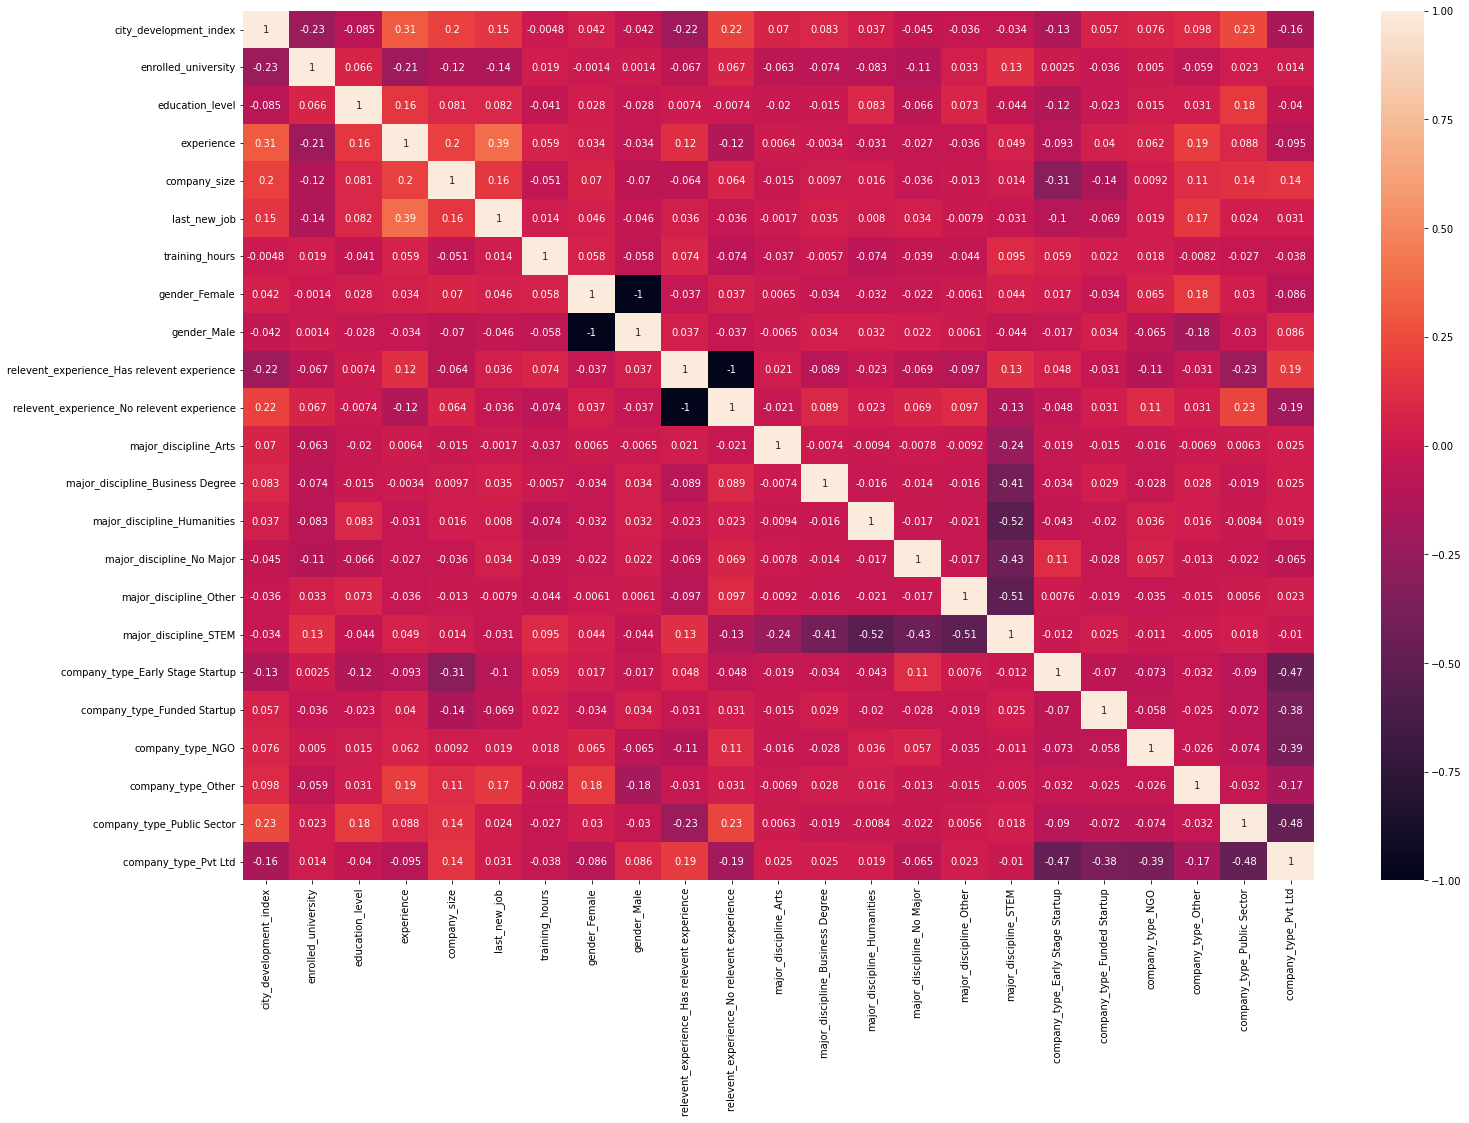

In [ ]:
# Plot the correlation heatmap between pairs of features
%matplotlib inline
plt.figure(figsize = (24,16))
sns.heatmap(data.corr(), annot = True)

Since there is no highly correlated attributes except those encoded using one hot encoding, we will not remove anything.

## Step 3: Data Analysis

Next, we will split the processed dataset into 2 sets: training and testing. 70% of the data will be put in the training set and 30% will be put in the testing set. 

In [ ]:
# Train/test split with a 7:3 ratio
X_train, X_test, y_train, y_test = train_test_split(data.values, labels.values,
                                                    random_state = 1,
                                                    test_size = 0.3)

Let's focus on the training set. For each unique label (1 and 0), we will print out the number of values to see whether or not this set is imbalanced.

In [ ]:
# Print number of labels' entries
print(np.unique(y_train, return_counts = True))    

(array([0., 1.]), array([742, 752]))


It is clear that our training set is quite balanced. There are 742 entries labeled "0" and 752 entries labeled "1". Therefore, we do not have to apply techniques for imbalanced dataset.

## Step 4: Decision Tree Prediction Model
Since our output labels are categorical ("0" and "1") and the dataset is balanced, we will directly apply a classification Decision Tree on our training set.

### 4.1. With Original Data

But first, we must find the best hyper-parameters for the Decision Tree model. We set the tree's maximum depth to be from 4 to 10 since there is 11 original attributes. Besides, we also set the minimum numner of samples for stop splitting to be from 3 to 9 to avoid overfitting.

In [ ]:
# Criteria for the hyper-parameters
params = {"criterion": ["gini", "entropy"],        # Criterion to evaluate the purity.
         "max_depth": range(4, 11),                     # Maximum depth of the tree
         "min_samples_split": range(3, 10)}              # Stop splitting condition.

# Find the best hyper-parameters for our training dataset with 5-fold cross-validation
grid_search = GridSearchCV(estimator = DecisionTreeClassifier(),
                           param_grid = params, cv = 5)
grid_search.fit(X_train, y_train)

# Best set of hyper-parameters found after searching
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 9}

Since the above hyper-parameters make sense to us, we will use it to train the Decision Tree model.

In [ ]:
# Build a Decision Tree model pipeline from the best set of hyper-parameters found
model_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7,
                                  min_samples_split = 9)

# Train the Decision Tree model
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=9)

We will evaluate the trained Decision Tree model above by applying it on the original test set.

In [ ]:
# Make prediction on the original test set
pred_y = model_dt.predict(X_test)
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80       293
         1.0       0.86      0.76      0.80       348

    accuracy                           0.80       641
   macro avg       0.80      0.80      0.80       641
weighted avg       0.81      0.80      0.80       641



We can see the classification tree that we have trained

In [ ]:
# Save model as .dot
tree.export_graphviz(decision_tree = model_dt, out_file = 'decision-tree.dot',
                     feature_names = data.columns)     

# Convert the model to an image
call(['dot', '-Tpng', 'decision-tree.dot', '-o', 'decision-tree.png', '-Gdpi=300']) 

# Show the image
Image(filename = 'decision-tree.png')

and also the most important features that may be used to split the dataset.

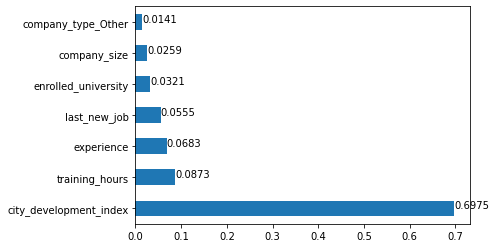

In [ ]:
# Generate Series containing importance level
weights = model_dt.feature_importances_      
cols = data.columns                          
feature_importances = pd.Series(weights, index=cols)     

# Plot the 7 most important features with their score
%matplotlib inline
n_largest = feature_importances.nlargest(7).plot(kind='barh')
[n_largest.text(v, i, '{:.4f}'.format(v)) for i, v in enumerate(feature_importances.nlargest(7))];

It is clear that `city_development_index` has the most important score. Consequently, the tree first uses `city_development_index` to split the dataset. 

### 4.1. With SMOTE

Because the scores of the above evaluation metrics (precision, recall, and f1-score) are quite low (~0.81), we will try to apply SMOTE to over-sample the training set. The intuition behind this action is that we want to see whether we can obtain a better prediction using SMOTE.

In [ ]:
# Initialize SMOTE
smote = SMOTE(random_state = 5)     

# Oversample label '1' (minority class) in the training set
X_train_oversampling, y_train_oversampling = smote.fit_resample(X_train, y_train)     

To confirm that SMOTE is sucessfully done,  we will check whether number of entries in each label are the same.

In [ ]:
# Print number of labels' entries
print(np.unique(y_train_oversampling, return_counts = True))

(array([0., 1.]), array([752, 752]))


As you can see, label '0' and '1' have the same number of entries. Next, we will find the best hyper-parameters for the Decision Tree model. The criteria for the hyper-parameters will remain the same.

In [ ]:
# Find the best hyper-parameters for our training dataset with 5-fold cross-validation
grid_search_oversampling = GridSearchCV(estimator = DecisionTreeClassifier(),
                                        param_grid = params, cv = 5)
grid_search_oversampling.fit(X_train_oversampling, y_train_oversampling)

# Best set of hyper-parameters found after searching
grid_search_oversampling.best_params_

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 8}

Since the above hyper-parameters make sense to us, we will use it to train the Decision Tree model.

In [ ]:
# Build a Decision Tree model pipeline from the best set of hyper-parameters found
model_dt_oversampling = DecisionTreeClassifier(criterion = 'gini',
                                               max_depth = 7,
                                               min_samples_split = 8)

# Train the Decision Tree model
model_dt_oversampling.fit(X_train_oversampling, y_train_oversampling)

DecisionTreeClassifier(max_depth=7, min_samples_split=8)

We will evaluate the trained model above by applying it on the original test set.

In [ ]:
# Make prediction on the original test set
pred_y_oversampling = model_dt_oversampling.predict(X_test)
print(classification_report(y_test, pred_y_oversampling))

              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78       293
         1.0       0.82      0.80      0.81       348

    accuracy                           0.80       641
   macro avg       0.79      0.80      0.79       641
weighted avg       0.80      0.80      0.80       641



Since the overall score does not differ much from that of the DT model without SMOTE, we decide not to apply SMOTE. Consequently, we will **stick to the original training dataset** when training other Decision Tree/Random Forest models.

## Step 5: Random Forest Prediction Model

To begin, we will find the best hyper-parameters for the Random Forest model. The criteria for the hyper-parameters will remain the same except there is an additional parameter called `n_estimators` representing the number of trees in the forest. For this parameter, we will set it to 10 cause 10 seems reasonable to us.

An important thing to remind is that we are going to work on the original dataset instead of the oversampling one. The reason is that the latter not only does not improve the prediction much but also change the dataset's characteristics.

In [ ]:
# Find the best hyper-parameters for our training dataset with 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 10,
                                                                 n_jobs = 10),
                              param_grid = params, cv = 5) 
grid_search_rf.fit(X_train, y_train)

# Best set of hyper parameters of the Random Forest
grid_search_rf.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 6}

Since the above hyper-parameters make sense to us, we will use it to train the Random Forest model.

In [ ]:
# Build a Random Forest model pipeline from the best set of hyper-parameters found
model_rf = RandomForestClassifier(n_estimators = 10, random_state = 1,
                                  criterion = 'entropy', max_depth = 10,
                                  min_samples_split = 6)  

# Train the Random Forest model
model_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=6,
                       n_estimators=10, random_state=1)

We will evaluate the trained model above by applying it on the original test set.

In [ ]:
# Make prediction on the original test set
pred_y = model_rf.predict(X_test)
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       293
         1.0       0.86      0.86      0.86       348

    accuracy                           0.85       641
   macro avg       0.85      0.85      0.85       641
weighted avg       0.85      0.85      0.85       641



It is clear that the Random Forest model performs better than the Decision Tree model although the gap is not that large (0.3 increase only).

Because our Random Forest model consists of 10 different trees, we cannot visualize the whole forest. However, we can see individual tree in the forest. To minimize the notebook, we will plot the first and last tree in our forest only.

In [ ]:
# Visualize tree 1 in our random forest
tree.export_graphviz(decision_tree = model_rf[0], out_file = 'random-forest-1.dot',
                     feature_names = data.columns)     
call(['dot', '-Tpng', 'random-forest-1.dot', '-o', 'random-forest-1.png', '-Gdpi=300']) 
Image(filename = 'random-forest-1.png')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Visualize tree 10 in our random forest
tree.export_graphviz(decision_tree = model_rf[-1], out_file = 'random-forest-10.dot',
                     feature_names = data.columns)     
call(['dot', '-Tpng', 'random-forest-10.dot', '-o', 'random-forest-10.png', '-Gdpi=300']) 
Image(filename = 'random-forest-10.png')

And we can also see the feature importance scores of those tree, which may be used to split the datasets.

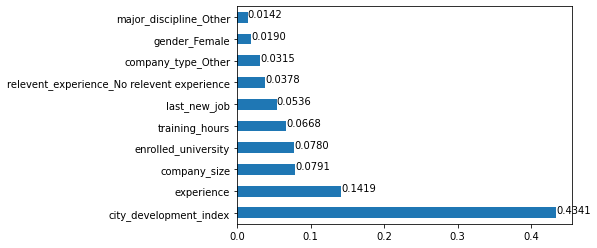

In [ ]:
%matplotlib inline

# Feature importance scores of tree 1
weights = model_rf[0].feature_importances_      
feature_importances = pd.Series(weights, index = data.columns)     
n_largest = feature_importances.nlargest(10).plot(kind='barh')
[n_largest.text(v, i, '{:.4f}'.format(v)) for i, v in enumerate(feature_importances.nlargest(10))];

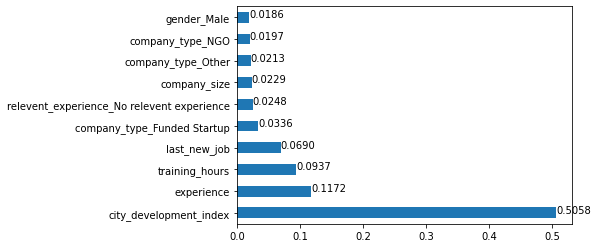

In [ ]:
%matplotlib inline

# Feature importance scores of tree 10
weights = model_rf[-1].feature_importances_      
feature_importances = pd.Series(weights, index = data.columns)     
n_largest = feature_importances.nlargest(10).plot(kind='barh')
[n_largest.text(v, i, '{:.4f}'.format(v)) for i, v in enumerate(feature_importances.nlargest(10))];

It is clear that `city_development_index` has the most important score in the two tree above, which is similar to the first Decision Tree we built. However, the its important scores differ, which I believe due to the changing maximum depth value.